In [28]:
main_prefix = '/home/mikc/Documents/MachineLearning/Datasets/Segmentation/CelebAMask-HQ/'
mapping_file = main_prefix + 'catalog.csv'
mask_dir = main_prefix + 'CelebAMask-HQ-mask-anno/'

BATCH_SIZE=40
#TRAIN_SET_SIZE = 10000
TRAIN_SET_SIZE = 3000
VALIDATION_SET_SIZE = 2000
EPOCHS = 10

##### !!!!!!!!!!!!
##### Crucial - classes must be sorted in a way they don't hide each other,
#####           if skin goes after eyes, it hides them since it covers the whole face
##### !!!!!!!!!!!

CATEGORIES = [
'skin',
'neck',    
'hair',
'l_brow',
'l_ear',
'l_eye',
'l_lip',
'mouth',
'neck_l',
'nose',
'r_brow',
'r_ear',
'r_eye',
'u_lip',
'ear_r',
'cloth',
'hat',
'tore',
'eye_g'
]

#CATEGORIES=['skin']

TARGET_SIZE = (256, 256)


In [29]:
import pandas as pd
mapping = pd.read_csv(mapping_file,  index_col='image_id')
mapping.head()
#for index, row in mapping.iterrows():
#    print("index="+index+", row="+row['prefix'])

,prefix
image_id,
CelebA-HQ-img/0.jpg,CelebAMask-HQ-mask-anno/0/00000
CelebA-HQ-img/10000.jpg,CelebAMask-HQ-mask-anno/5/10000
CelebA-HQ-img/10001.jpg,CelebAMask-HQ-mask-anno/5/10001
CelebA-HQ-img/10002.jpg,CelebAMask-HQ-mask-anno/5/10002
CelebA-HQ-img/10003.jpg,CelebAMask-HQ-mask-anno/5/10003


In [30]:
def get_image_prefix(image_id):
    return main_prefix + str(mapping.loc[image_id]['prefix'])

get_image_prefix('CelebA-HQ-img/0.jpg')



'/home/mikc/Documents/MachineLearning/Datasets/Segmentation/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00000'

In [31]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image




In [32]:
def show_mask(img, mask, alpha=0.9):
    fig, ax = plt.subplots()
    # Display the image
    img += 1.0
    img *= 0.5
    #print(img)
    ax.imshow(img)
    one_hot = mask[:,0].reshape(TARGET_SIZE)
    ax.imshow(one_hot, alpha=alpha)
    plt.show()

In [33]:
from keras.applications import imagenet_utils
from keras.preprocessing import image
import numpy as np
import os
import itertools

def preprocess_image_input(file_name):
    """
    Preprocess image files for tensorflow
    """
    img = image.load_img(main_prefix+file_name, target_size=TARGET_SIZE)
    X = image.img_to_array(img)
    return imagenet_utils.preprocess_input(X, mode='tf')

def init_classes():
    return np.zeros((TARGET_SIZE[0], TARGET_SIZE[1], 1))


def preprocess_mask(file_name, classes_to_recognize):
    Y = init_classes()
    idx = 1
    for clz in classes_to_recognize:
        Y[:,:, 0] = preprocess_given_class_from_image_mask(Y[:,:,0], file_name, clz, idx)
        idx += 1
    # Flatten and return
    return Y.reshape(TARGET_SIZE[0]*TARGET_SIZE[1], 1).astype(int)
        
def preprocess_given_class_from_image_mask(Y, file_name, class_given, idx):
    """
    Preprocess given class into numpy array
    """
    mask_file = main_prefix+file_name+"_"+class_given+".png"
    if os.path.exists(mask_file):
        img = image.load_img(mask_file, target_size=TARGET_SIZE)
        X = image.img_to_array(img)[:,:,0]
        ####
        #### This is super-crucial - how to encode the image that represents the classes
        ####
        X[X>0] = idx
        Y = X + Y*(X==0).astype(int)
    return Y
        
        

def get_pairs_from_paths():
    image_pairs=[]
    
    for index, row in mapping.iterrows():
       #print("index="+index+", row="+row['prefix'])
       if os.path.exists(main_prefix+index):
           image_pairs.append((index, row['prefix']))  

    return image_pairs
    
    
def image_set_generator(to_learn, batch_size=128, cache=None):
    img_seg_pairs = to_learn
    random.shuffle(img_seg_pairs)
    zipped = itertools.cycle(img_seg_pairs)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)
            #print(im)
            #print(seg)
            if cache is not None:
                X.append(cache[im])
                Y.append(cache[seg])
            else:
                X.append(preprocess_image_input(im))
                Y.append(preprocess_mask(seg, CATEGORIES))
        #print(np.array(X))
        yield (np.array(X), np.array(Y))

#preprocess_input('CelebA-HQ-img/0.jpg')

def create_cache(to_learn):
    cache = {}
    L = 0
    for (img, cat) in to_learn:
        cache[img] = preprocess_image_input(img)
        cache[cat] = preprocess_mask(cat, CATEGORIES)
        if (L % 100) == 0:
            print("L="+str(L))
        L += 1
    return cache


#preprocess_mask('CelebAMask-HQ-mask-anno/0/00000', CATEGORIES).shape
#next(image_set_generator())

all_images = get_pairs_from_paths()
to_train = all_images[0:TRAIN_SET_SIZE]
to_validate = all_images[TRAIN_SET_SIZE:TRAIN_SET_SIZE + VALIDATION_SET_SIZE]
cache = None
#cache = create_cache(to_learn)
#len(cache)
len(to_validate)

2000

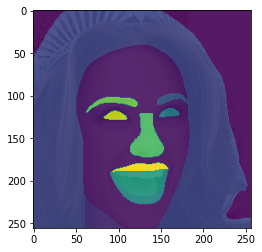

In [34]:
#preprocess_mask('CelebAMask-HQ-mask-anno/0/00000', CATEGORIES)[:,1].reshape((256,256))
show_mask(preprocess_image_input('CelebA-HQ-img/0.jpg'), preprocess_mask('CelebAMask-HQ-mask-anno/0/00000', CATEGORIES))


In [35]:
train_generator = image_set_generator(to_train, batch_size=BATCH_SIZE, cache=cache)
validation_generator = image_set_generator(to_validate, batch_size=BATCH_SIZE, cache=cache)
next(validation_generator)

(array([[[[ 0.654902  ,  0.67058825,  0.6313726 ],
          [ 0.6392157 ,  0.654902  ,  0.6156863 ],
          [ 0.6313726 ,  0.64705884,  0.60784316],
          ...,
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943]],
 
         [[ 0.6313726 ,  0.64705884,  0.60784316],
          [ 0.6156863 ,  0.6313726 ,  0.5921569 ],
          [ 0.62352943,  0.6392157 ,  0.6       ],
          ...,
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943]],
 
         [[ 0.62352943,  0.6392157 ,  0.6       ],
          [ 0.6       ,  0.6156863 ,  0.5764706 ],
          [ 0.6       ,  0.6156863 ,  0.5764706 ],
          ...,
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943],
          [ 0.6784314 ,  0.6862745 ,  0.62352943]],
 
         ...,
 
         [[ 

In [36]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import np_utils


def to_categorical(y, nb_classes):
    num_samples = len(y)
    Y = np_utils.to_categorical(y.flatten(), nb_classes)
    return Y.reshape((num_samples, y.size / num_samples, nb_classes))

def SegNet(input_shape=(512, 512, 3), classes=12):
    # c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Convolution2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Convolution2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Decoder
    x = Convolution2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #ZeroPadding2D(((1, 0), (0, 0)))
    
    x = Convolution2D(classes, (1, 1), padding="valid")(x)
    x = Reshape((input_shape[0]*input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model

In [37]:

from keras.optimizers import RMSprop, Adam, SGD
import tensorflow as tf

#opt = Adam()
#opt = SGD(lr=0.01, decay=0.01/EPOCHS, momentum=0.8, nesterov=True)
opt = 'adam'
loss = 'sparse_categorical_crossentropy'
model = SegNet(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), classes=1+len(CATEGORIES))
model.compile(
    loss=loss, 
    optimizer = opt, 
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 128)     512 

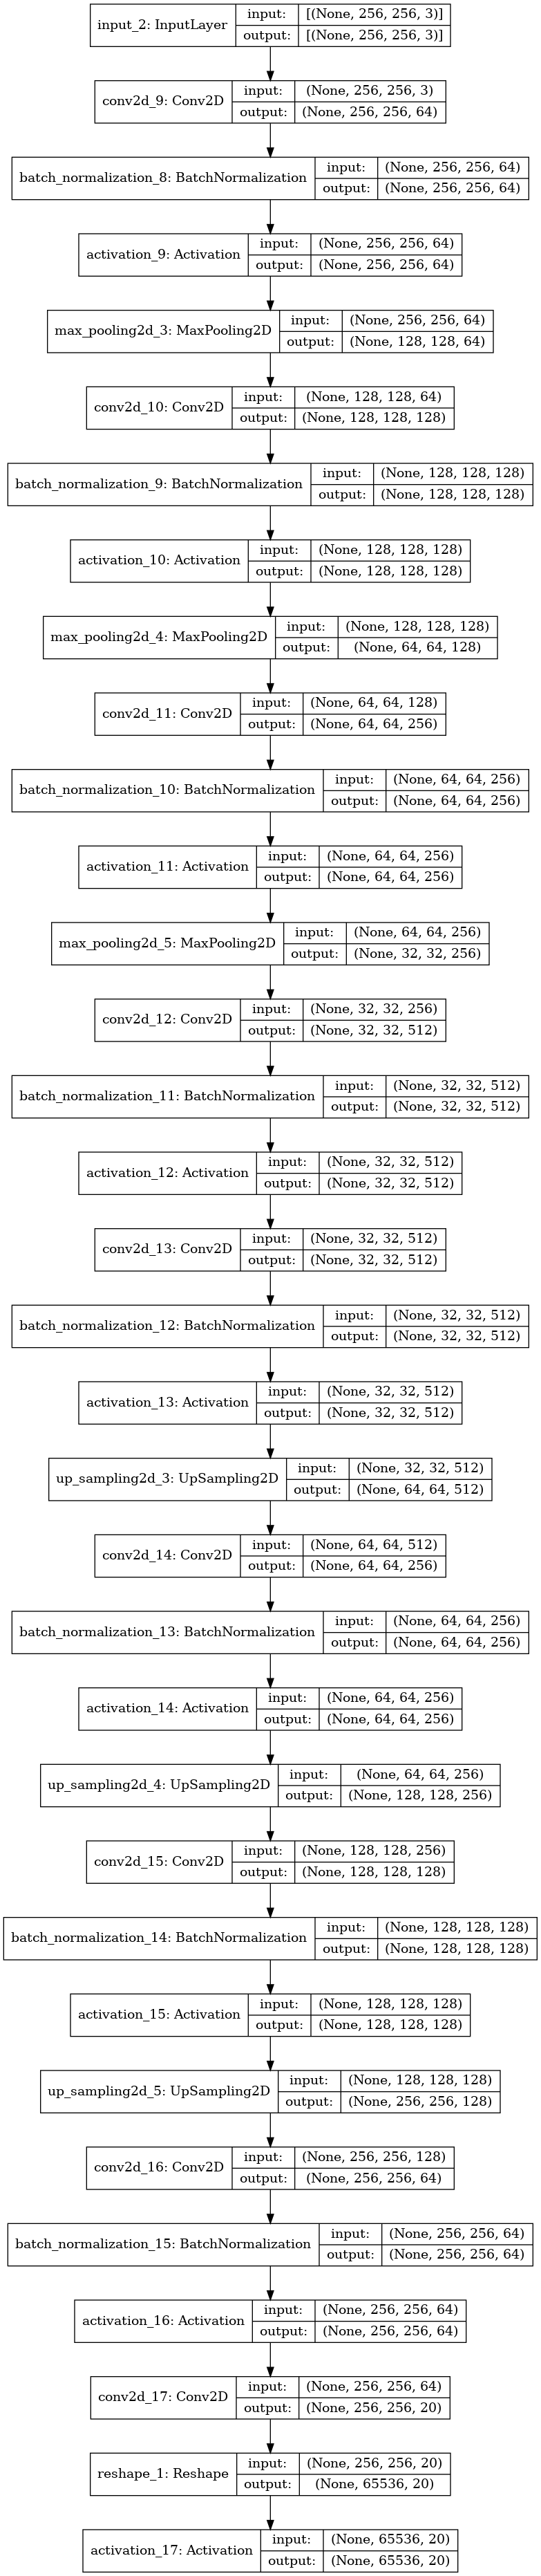

In [38]:
from IPython.display import Image 
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')


In [39]:
from keras.callbacks import ModelCheckpoint
fname=main_prefix+"weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

hist=model.fit_generator(
    train_generator,
    steps_per_epoch=TRAIN_SET_SIZE // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SET_SIZE // BATCH_SIZE,
    verbose=1,
    
    callbacks=checkpoint,
    epochs=EPOCHS)

/home/mikc/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1878: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 1388s 19s/step - loss: 1.5516 - accuracy: 0.2799 - val_loss: 4.3530 - val_accuracy: 0.6840

Epoch 00001: val_loss improved from inf to 4.35303, saving model to /home/mikc/Documents/MachineLearning/Datasets/Segmentation/CelebAMask-HQ/weights-001-4.3530.hdf5
Epoch 2/10
75/75 [==============================] - 1382s 18s/step - loss: 0.7667 - accuracy: 0.2988 - val_loss: 2.9215 - val_accuracy: 0.9921

Epoch 00002: val_loss improved from 4.35303 to 2.92151, saving model to /home/mikc/Documents/MachineLearning/Datasets/Segmentation/CelebAMask-HQ/weights-002-2.9215.hdf5
Epoch 3/10
75/75 [==============================] - 1384s 18s/step - loss: 0.5980 - accuracy: 0.2959 - val_loss: 2.8426 - val_accuracy: 0.9653

Epoch 00003: val_loss improved from 2.92151 to 2.84262, saving model to /home/mikc/Documents/MachineLearning/Datasets/Segmentation/CelebAMask-HQ/weights-003-2.8426.hdf5
Epoch 4/10
75/75 [==============================] - 1380s 18s/ste

In [40]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(val_loss)+1)

<Figure size 432x288 with 0 Axes>

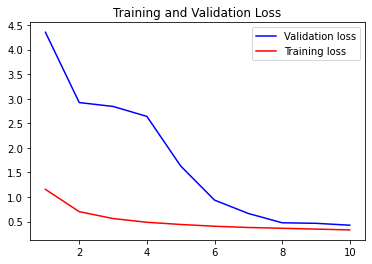

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

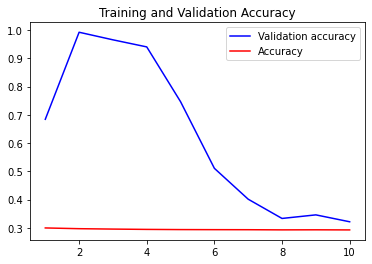

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, acc, 'r', label='Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

In [77]:

def get_prediction(image_name):
    Xorig = preprocess_image_input(image_name)
    X =  np.expand_dims(Xorig, axis=0)
    Y = model.predict([X])
    Y = Y[0] # get rid of the "batch" since Y.shape == (1, 65536, 20)
    classes = Y.shape[1]
    print(Y.shape)
    Z = Y.reshape(TARGET_SIZE[0], TARGET_SIZE[1], classes)
    out = np.zeros(TARGET_SIZE)
    for x in range(0, TARGET_SIZE[0]):
        for y in range(0, TARGET_SIZE[1]):
            label = np.argmax(Z[x, y, :])
            out[x,y] = label
    return out
    


(65536, 20)


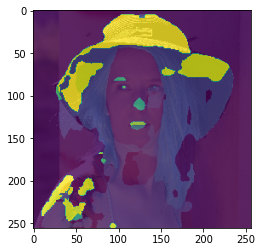

In [83]:


img_file = 'CelebA-HQ-img/0.jpg'
img_file = 'Katri/katri01_face.jpg'
prediction = get_prediction(img_file)
img = image.load_img(main_prefix+img_file, target_size=TARGET_SIZE)
fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(prediction, alpha=0.8)
plt.show()

